# Computational Assignment 2: The Trebuchet

Participants: Ingve Aleksander Hetland & Andreas Nossum

A legion of soldiers stands confidently at the top of their stone walls as the siege is about to begin. Although many have tried, the castle has not been breached ever before. The walls are too thick and sturdy, and the king can continue living comfortably behind the safety of stone and wood. But in the distance a soldier catches a glimpse of what will cause a turn of the tide. At the opposite side of the green field the mighty trebuchet is now making its arrival.

A trebuchet is known as the largest and most destructive type of catapult used in the middle ages. To simplify, the design of a trebuchet consists of a beam placed on a pole with a weight on one of the sides. On the other side, one can usually find a pouch filled with the desired projectile. The whole contraption then has a resemblance to a seesaw. And just like at the playground, when two kids jump on one of the sides at the same time, the third kid on the other side will be catapulted upwards.

This numerical assignment will analyze the motion of a projectile launched by such a trebuchet. We first start by importing relevant libraries.

In [1]:
# Importing relevant libraries
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from IPython.display import display, Math, Markdown

newparams = {'figure.figsize': (10, 6), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

We will use a counterweight and projectile much heavier than a couple of kids at a playground, and we have defined parameters based on a trebuchet reconstruction in Denmark.

In [2]:
# Constants throughout the assignment, table 1
m1 = 2000     # kg,    mass of counterweight
m2 = 15       # kg,    mass of projectile
l1 = 1.2      # m,     short part of main beam
l2 = 5.7      # m,     long part of main beam
l3 = 3.2      # m,     stand
l4 = 5        # m,     projectile sling
g = 9.81      # m/s^2,     gravitational constant
theta0 = 0.7*np.pi     # rad,     theta at t = 0
dtheta0 = 0.0 # rad/s,     dtheta at t = 0
psi0 = theta0 - 0.5*np.pi       # rad,     psi at t = 0
dpsi0 = 0.0   # rad/s,     dpsi at t = 0

def init_params(theta=0.7*np.pi, dtheta=.0, psi=0.5*np.pi, dpsi=.0):
    global theta0
    theta0 = theta
    
    global dtheta0
    dtheta0 = dtheta
    
    global psi0
    psi0 = theta0 - psi
    
    global dpsi0
    dpsi0 = dpsi
    

Unfortunately, the soldiers during the middle ages did not have the knowledge, nor the skills to operate a Python problem as we do. But neither do we have the skills to operate a six ton wooden killing-machine. Either way, a couple of centuries later, we can now use the power of computers to simulate what these soldiers did way back. To do so we need some equations of motion (EOM) and a suitable EOM-solver. First, we look at the EOM for pure projectile motion without air resistance, before we move on to the EOM for the swinging motion of the trebuchet itself.

In [3]:
def omega_projectile(x, y, vx, vy):
    """
    INPUT:
    x:     float,     x-coordinate
    y:     float,     y-coordinate
    vx:    float,     x-component of velocity
    vy:    float,     y-component of velocity
    ---
    Returns a one-dimensional array with the quantities of interest for solving the equations of motion
    """
    return np.array([x,
                     y,
                     vx,
                     vy], dtype="float64")

def EOM_projectile(t, w):
    """
    INPUT:
    t:     float,     Current time in calculations
    w:     1D array,  Array with quantities of interest, corresponds to left side of 1st order representation of equations of motion
    ---
    Returns a 1D array with the right hand side of the 1st order representation of equations of motion
    """
    return np.array([w[2],
                     w[3],
                     0,
                     -g], dtype="float64")

The method for our ODE-solver will be Runge-Kutta of 4th order (RK4). This algorithm will eat the EOM we feed it, perform one step of the method, and then spit out the next configuration of the variables we are interested in. One step is not enough, but by doing this process enough times, eventually the motion of the EOM will show up. We implement it here as `RK4()`

In [4]:
def RK4(f, t, w, h):
    """
    INPUT:
        f:         function,     Vector of equations, w'(t) = f(t, w)
        t:         float,        Time at calculation
        w:         1D array,     Function containing quantities of interest
        h:         float,        Step length
    ---
    Performs one step of the classic Runge-Kutta 4 method for solving ODEs
    ---
    OUTPUT:
        t_next:    float,        Next time in calculation
        w_next:    1D array,     New values for functions in w
    """
    k1 = f(t, w)
    k2 = f(t + h/2, w + h*k1/2)
    k3 = f(t + h/2, w + h*k2/2)
    k4 = f(t + h, w + h*k3)

    t_next = t + h
    w_next = w + h*(k1/6 + k2/3 + k3/3 + k4/6)
    return t_next, w_next

We define functions which will iterate the ODE-solvers over all time-steps, `trebuchet()` for the swinging of the trebuchet and `projectile()` for the projectile motion. For solving the full motion of the projectile, we will compute the trajectory of the swinging, then use the final position and velocity of the projectile as initial parameters for the projectile motion. The solving of the swingning motion is halted when a predetermined release angle $\theta_r$ is achieved or the simulation has run for a set time-interval $T$, and the projectile calculations are halted when the projectile has a negative $y$-coordinate i.e. it is underground. The exact landing point is then calculated with linear interpolation.

In [5]:
def projectile(f, omega, r0, v0, method=RK4, h=0.01):
    """
    INPUT:
    f:         function,     Returns 1D array with right hand side of 1st order representation of equations of motion
    omega:     function,     Returns 1D array with left hand side of 1st order representation of equations of motion, quantities of interest
    r0:        1D array,     Initial position of form [x, y]
    v0:        1D array,     Initial velocity of form [vx, vy]
    method:    function,     Performs one step of numerical method and returns updated quantities, we only use RK4
    h:         float,        Step-length
    ---
    Solves the equations of motion given by f and quantities of interest numerically until projectile is detected underground,
    while constructing arrays for position, velocity and time. Also uses interpolation to calculate exact position where
    the projectile hits the ground.
    ---
    OUTPUT:
    r:        2D array,     Array of position vectors for every time-step
    v:        2D array,     Array of velocity vectors for every time-step
    time:     1D array,     Array with every time-step
    rl:       1D array,     Position vector when projectile hits the ground
    """
    
    r = np.array([r0])                # Array with positions [x, y, z], will fill up as projectile moves
    v = np.array([v0])                # Array with corresponding velocities in each direction [x, y, z]

    w = omega(r0[0], r0[1], v0[0], v0[1])     # Construct vector with initial values for left hand side of EOM
    t = 0                             # Time of release
    time = np.array([t])
    
    # Iterate while projectile is above or at ground level
    while w[1] > 0:
        t, w = method(f, t, w, h)     # Using method of choice to calculate next configuration of place and velocity

        # Arrays with next position/velocity respectively for each step 
        rnext = np.array([w[:2]])
        vnext = np.array([w[2:]])
        
        # Storing each position, velocity and time to corresponding main array for each step
        r = np.concatenate((r, rnext), axis=0)
        v = np.concatenate((v, vnext), axis=0)
        time = np.append(time, t)

    # Calculating where the projectile has reached the ground by linear interpolation
    q = - r[-2, 1]/r[-1, 1]
    xl = (r[-2, 0] + q*r[-1, 0])/(q + 1)
    
    rl = np.array([xl, 0])         # Final position vector
    r[-1] = rl                     # Add final position vector to main array

    return r, v, time, rl

def trebuchet(f, omega, omega0, thetar, T, method=RK4, h=0.01):
    """
    INPUT
    f:         function,     Returns 1D array with right hand side of 1st order representation of equations of motion
    omega:     function,     Returns 1D array with left hand side of 1st order representation of equations of motion, quantities of interest
    omega0:    1D array,     Array of starting values used in calculations
    thetar:    float,        Release angle
    method:    function,     Performs one step of numerical method and returns updated quantities, we only use RK4
    h:         float,        Step-length
    ---
    ODE-solver which iterates with a given method for variables in omega and EOM given by f. Release condition is thetar and starting
    values in omega0. Time step-length is h.
    ---
    t:         1D array,     Array of time values
    w:         2D array,     Array of omega vectors for every time value
    """
    angles = np.array([omega0])
    w = omega0
    
    t = 0
    time = np.array([t], dtype="float64")
    
    while w[0] > thetar and t <= T:
        t, w = method(f, t, w, h)     # Using method of choice to calculate next time and omega vector
        
        # Store values
        angles = np.concatenate((angles, np.array([w])), axis=0)
        time = np.append(time, t)
    
    return time, angles

## Task 1

We start with the position vectors $\vec{r}_1$ and $\vec{r}_{2b}$ and differentiate with respect to time to get the velocities of the masses $\vec{v_1}\text{ and }\vec{v_{2b}}$ as functions of $\theta\text{, }\psi\text{, } \dot{\theta}\text{, and }\dot{\psi}$

$$
\vec{r}_1 = \begin{bmatrix} l_1 \sin(\theta) \\ - l_1 \cos(\theta) + l_3 \end{bmatrix}
$$

$$
\vec{v}_1 = \frac{d \vec{r}_1}{dt} = \begin{bmatrix} l_1 \cos(\theta) \dot\theta \\  l_1 \sin(\theta) \dot\theta \end{bmatrix}
$$

and

$$
\vec{r}_{2b} = \begin{bmatrix} - l_2 \sin(\theta) - l_4 \sin(\psi - \theta) \\ l_2 \cos(\theta) + l_3 -l_4 \cos(\psi - \theta) \end{bmatrix}
$$

$$ 
\vec{v}_{2b} =  \frac{d \vec{r}_{2b}}{dt} = \begin{bmatrix} - l_2 \cos(\theta) \dot\theta - l_4 \cos(\psi - \theta)(\dot\psi - \dot\theta) \\ - l_2 \sin(\theta) \dot\theta + l_4 \sin(\psi - \theta)(\dot\psi - \dot\theta) \end{bmatrix}
$$

We then write down expressions of the kinetic energy $T$ and the potential $V$ of the system.

$$
T = \sum_i\frac{1}{2}m_iv_i^2 = \frac{1}{2}m_1l_1^2\dot{\theta}^2+\frac12 m_2 \left[ l_2^2\dot{\theta}^2 + l_4^2\left(\dot{\psi}-\dot{\theta} \right)^2 + 2l_2l_4\left(\dot{\psi}-\dot{\theta} \right)\dot{\theta}\left(\cos(\theta) \cos(\psi-\theta) - \sin(\theta) \sin(\psi-\theta) \right) \right] \\
T = \frac12 \left(m_1l_1^2+m_2l_2^2 \right)\dot{\theta}^2+\frac12 m_2l_4^2\left(\dot{\psi}-\dot{\theta}\right)^2 + m_2l_2l_4\left(\dot{\psi}-\dot{\theta}\right)\dot{\theta}\cos(\psi) \\
\\
V = \sum_im_igh_i = m_1g\left(l_3-l_1\cos(\theta)\right) + m_2g\left(l_2\cos(\theta)+l_3-l_4\cos(\psi-\theta)\right) \\
V = gl_3(m_1+m_2)-g(m_1l_1-m_2l_2)\cos(\theta)-gm_2l_4\cos(\psi-\theta)
$$

Consequently, the Lagrangian $L=T-V$ becomes

$$
L = \frac12 \left(m_1l_1^2+m_2l_2^2 \right)\dot{\theta}^2+\frac12 m_2l_4^2\left(\dot{\psi}-\dot{\theta}\right)^2 + m_2l_2l_4\left(\dot{\psi}-\dot{\theta}\right)\dot{\theta}\cos(\psi) - gl_3(m_1+m_2) + g(m_1l_1-m_2l_2)\cos(\theta) + gm_2l_4\cos(\psi-\theta)
$$

The Euler-Lagrange equation for the generalized coordinates is 

$$
\frac{\partial L}{\partial q} - \frac{d}{dt}\frac{\partial L}{\partial \dot q} = 0
$$

where $q$ is the coordinate in focus. We will start by looking at $\theta$:

$$
\frac{\partial L}{\partial \theta} = -g(m_{1} l_{1} + m_{2} l_{2}) \sin(\theta) + gm_{2}l_{4} \sin(\psi - \theta)
$$

$$
\frac{\partial L}{\partial \dot \theta} = (m_{1}l_{1}^2 + m_{2}l_{2}^2) \dot \theta - m_{2}l_{4}^2(\dot \psi - \dot \theta) + m_{2}l_{2}l_{4}(\dot \psi - \dot \theta) \cos(\psi) - m_{2}l_{2}l_{4}\dot \theta \cos(\psi)
$$

$$
\frac{d}{dt} \frac{\partial L}{\partial \dot \theta} = (m_{1}l_{1}^2 + m_{2}l_{2}^2) \ddot \theta + m_{2}l_{4}^2(\ddot \psi - \ddot \theta) + m_{2}l_{2}l_{4}(\ddot \psi - \ddot \theta)\cos(\psi) -m_{2}l_{2}l_{4}(\dot \psi - \dot \theta)\sin(\psi) \dot \psi - m_{2}l_{2}l_{4}\ddot \theta \cos(\psi) + m_{2}l_{2}l_{4}\dot \theta \sin(\psi) \dot \psi
$$

The Euler-Lagrange equation is given by

$$
\frac{\partial L}{\partial \theta} - \frac{d}{dt}\frac{\partial L}{\partial \dot \theta} = 0
$$

which results in

$$
-g(m_{1} l_{1} + m_{2} l_{2}) \sin(\theta) + gm_{2}l_{4} \sin(\psi + \theta) - (m_{1}l_{1}^2 + m_{2}l_{2}^2) \ddot \theta - m_{2}l_{4}^2(\ddot \psi - \ddot \theta) - m_{2}l_{2}l_{4}(\ddot \psi - \ddot \theta)\cos(\psi) + m_{2}l_{2}l_{4}(\dot \psi - \dot \theta)\sin(\psi) \dot \psi + m_{2}l_{2}l_{4}\ddot \theta \cos(\psi) - m_{2}l_{2}l_{4}\dot \theta \sin(\psi) \dot \psi = 0
$$.

This can be written as

$$
 \left( - l_{1}^2 m_{1} - l_{2}^2m_{2}  + 2m_{2}l_{2}l_{4}\cos(\psi) - l_{4}^2 m_{2} \right) \ddot \theta + \left( - l_{4}m_{2}(l_{2}\cos(\psi) - l_{4}) \right)\ddot \psi  = gm_{1} l_{1}\sin(\theta) + gm_{2} (l_{2} \sin(\theta) - l_{4} \sin(\psi + \theta) ) - m_{2}l_{2}l_{4}(\dot \psi - 2\dot \theta)\sin(\psi) \dot \psi
$$

or $a_{11}\ddot \theta + a_{12}\ddot \psi = b_{1}$ where

$a_{11} = - l_{1}^2 m_{1} - l_{2}^2m_{2}  + 2m_{2}l_{2}l_{4}\cos(\psi) - l_{4}^2 m_{2} \\
a_{12} = - l_{4}m_{2}(l_{2}\cos(\psi) - l_{4}) \\
b_{1} = gm_{1} l_{1}\sin(\theta) + gm_{2} (l_{2} \sin(\theta) - l_{4} \sin(\psi + \theta) ) - m_{2}l_{2}l_{4}(\dot \psi - 2\dot \theta)\sin(\psi) \dot \psi$


Now we will do the same process for the other generalized coordinate $\psi$:

$$
\frac{\partial L}{\partial \psi} = - m_{2}l_{2}l_{4}\dot \theta(\dot \psi - \dot \theta)\sin(\psi) - gm_{2}l_{4}\sin(\psi - \theta)
$$

$$
\frac{\partial L}{\partial \dot \psi} = m_{2}l_{4}^2(\dot \psi - \dot \theta) + m_{2}l_{2}l_{4}\dot \theta \cos(\psi)
$$

$$
\frac{d}{dt} \frac{\partial L}{\partial \dot \psi} = m_{2}l_{4}^2(\ddot \psi - \ddot \theta) + m_{2}l_{2}l_{4}\ddot \theta \cos(\psi) - m_{2}l_{2}l_{4}\dot \theta \sin(\psi) \dot \psi
$$

which by Euler Lagrange equations results in 

$$
- m_{2}l_{2}l_{4}\dot \theta(\dot \psi - \dot \theta)\sin(\psi) - gm_{2}l_{4}\sin(\psi - \theta) - m_{2}l_{4}^2(\ddot \psi - \ddot \theta) - m_{2}l_{2}l_{4}\ddot \theta \cos(\psi) + m_{2}l_{2}l_{4}\dot \theta \sin(\psi) \dot \psi = 0
$$.

We rewrite into a nicer form and get

$$
\left( - l_{4}m_{2}(l_{2}\cos(\psi) - l_{4}) \right) \ddot \theta + \left( - m_{2}l_{4}^2 \right) \ddot \psi = l_{4}m_{2} \left( g\sin(\psi - \theta) - l_{2}\sin(\psi) \dot \theta^2 \right)
$$

or $a_{21}\ddot \theta + a_{22}\ddot \psi = b_{2}$ where

$a_{21} = - l_{4}m_{2}(l_{2}\cos(\psi) - l_{4}) = a_{12} \\
a_{22} = - m_{2}l_{4}^2 \\
b_{2} = l_{4}m_{2} \left( g\sin(\psi - \theta) - l_{2}\sin(\psi) \dot \theta^2 \right)$

Combining all this gives a matrix for the EOM on the form

$$
\begin{bmatrix} a_{11} & a_{12} \\ a_{12} & a_{22} \end{bmatrix} \begin{bmatrix} \ddot \theta \\ \ddot \psi \end{bmatrix} = \begin{bmatrix} b_{1} \\ b_{2} \end{bmatrix}
$$

which we implement numerically. We do this by defining `Ainv()` which computes $A^{-1}$, `b()` which computes $\vec{b}$, `omega_trebuchet()` which constructs a vector $\vec{\omega}$ that we use in our calculations, and lastly `EOM_trebuchet()` which is the right hand side (RHS) of the equation (i.e. $\vec{u}$):

$$
\frac{\text{d}}{\text{dt}}\vec{\omega} = \vec{u} \text{, where }\vec{\omega} = \begin{bmatrix} \theta \\ \psi \\ \dot{\theta} \\ \dot{\psi} \end{bmatrix}
$$

$\ddot{\theta}$ and $\ddot{\psi}$ are calculated using the above equation, $\theta$ and $\psi$ are simply set to $\dot{\theta}$ and $\dot{\psi}$ in the EOM.

In [6]:
# Defining mentioned functions

def Ainv(psi):
    """
    INPUT
    psi:     float,     Value for angle psi
    ---
    Constructs and returns the inverse of matrix A used in the ODE-solver
    """
    a11 = -l1**2*m1 - l2**2*m2 + 2*l2*l4*m2*np.cos(psi) - l4**2*m2
    a12 = -l4*m2*(l2*np.cos(psi) - l4)
    a22 = -l4**2*m2
    A = np.array([[a11, a12],
                  [a12, a22]], dtype="float64")
    return np.linalg.inv(A)

def b(theta, psi, dtheta, dpsi):
    """
    INPUT
    theta:     float,     Value for theta
    psi:       float,     Value for psi
    dtheta:    float,     time-derivative of theta
    dpsi:      float,     time derivative of psi
    ---
    Constructs and returns b-vector used in ODE-solver
    """
    b1 = g*m1*l1*np.sin(theta) - g*m2*(l2*np.sin(theta) + l4*np.sin(psi-theta)) - l2*l4*m2*(dpsi-2*dtheta)*np.sin(psi)*dpsi
    b2 = l4*m2*(g*np.sin(psi-theta) - l2*np.sin(psi)*dtheta**2)
    return np.array([b1,
                     b2], dtype="float64")

def omega_trebuchet(theta, psi, dtheta, dpsi):
    """
    INPUT
    theta:     float,     Value for theta
    psi:       float,     Value for psi
    dtheta:    float,     time-derivative of theta
    dpsi:      float,     time derivative of psi
    ---
    Constructs and returns array of values used in trebuchet calculations
    """
    return np.array([theta,
                     psi,
                     dtheta,
                     dpsi], dtype="float64")

def EOM_trebuchet(t, w):
    """
    INPUT
    t:     float,     Current time
    w:     1D array,  Omega array of variable values
    ---
    Constructs and returns array of equations of motion for the derivative of w
    """
    Ainverse = Ainv(w[1])
    bvec = b(w[0], w[1], w[2], w[3])
    return np.array([[w[2], w[3]], Ainverse @ bvec], dtype="float64").flatten()

## Task 2

Before we start slinging any stones, we need to see if our newly constructed weapon of war will hold up when the siege begins. For a start, the contraption's strength is put to the test by making it swing without releasing any projectile from its pouch. We will utilize the previously defined RK4-method to solve our EOM and thereby see the projectile's motion before it departs forever. We will run the simulation for increasing time-intervals $T$ and plot the resulting values for $\theta$, $\psi$, $\dot{\theta}$, and $\dot{\psi}$

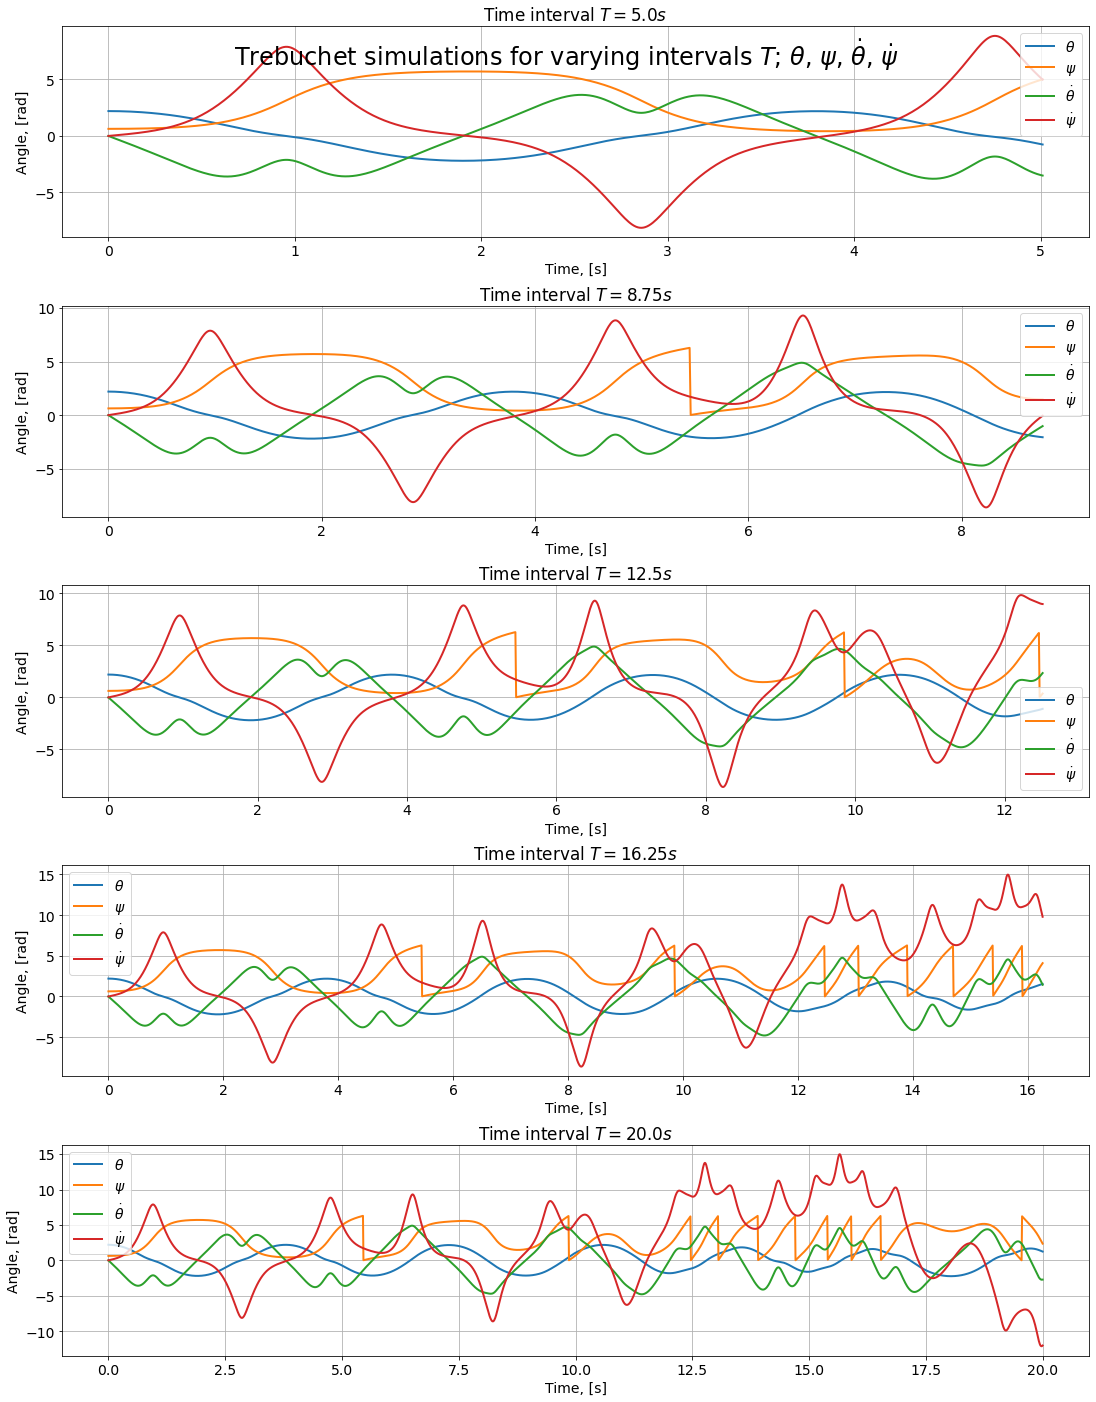

In [7]:
T_2 = np.linspace(5, 20, 5)
h = 0.01

w0_2 = omega_trebuchet(theta0, psi0, dtheta0, dpsi0)

fig, axs = plt.subplots(len(T_2), figsize=(16, 20))
fig.suptitle(r"Trebuchet simulations for varying intervals $T$; $\theta$, $\psi$, $\dot{\theta}$, $\dot{\psi}$", fontsize=24, y=0.96)
fig.tight_layout(pad=3)

for i, duration in enumerate(T_2):
    
    t2, w2 = trebuchet(EOM_trebuchet, omega_trebuchet, w0_2, -np.pi, duration)
    
    w2[:,1] = w2[:,1]%(2*np.pi)
    
    axs[i].plot(t2, w2[:, 0], label=r"$\theta$")
    axs[i].plot(t2, w2[:, 1], label=r"$\psi$")
    axs[i].plot(t2, w2[:, 2], label=r"$\dot{\theta}$")
    axs[i].plot(t2, w2[:, 3], label=r"$\dot{\psi}$")
    axs[i].set_title(fr"Time interval $T = {duration}s$")
    axs[i].set_xlabel("Time, [s]")
    axs[i].set_ylabel("Angle, [rad]")
    axs[i].legend()

From the plots, it is apparent that $\theta$ and consequently $\dot\theta$ are periodic, while $\dot{\psi}$ behaves quite chaotically. As a result $\psi$ also behaves a little chaotically, but since its derivative is mostly positive the arm spins in the positive direction. The chaotic motion of $\psi$ affects the motion of $\theta$. This is most apparent in the perturbations of $\dot{\psi}$ and $\theta$ after longer durations of time, but overall they behave in a periodic manner. This is to be expected since the behavior $\theta$ is largely determined by the large $m_1$ which needs large force to be disturbed and will therefore oscillate nicely without too much influence from the projectile's motion. In contrast, $\psi$ is dictated by the much smaller $m_2$ and also the motion of $m_1$, making it very prone to chaotic motion.

## Task 3

As the trebuchet is working as expected, the projectile is ready for take-off. We first define the functions `r_2b()` and `v_2b` which compute the position and velocity vectors of the projectile repectively as functions of $\theta$, $\psi$, $\dot{\theta}$, and $\dot{\psi}$. Afterwards we run simulations for both swinging and projectile motion as described above.

We are interested in how the release angle $\theta_r$ and the initial angles $\theta_0$ and $\psi_0$ affect the trajectory of the projectile. We therefore vary $\theta_r\in [0^{\circ}, 40^{\circ}]$ and compare the resulting trajectories. We then change the initial throwing arm angle to $\theta_0 = 0.9\pi$ and run the simulations again, and lastly we change the initial sling angle to $\psi_0 = 0$ and yet again run the simulations.

Projectile travels in a positive x-directions for release angles smaller than $32^{\circ}$; $\theta_0 = 0.7\pi$, $\psi_0 = 0.2\pi$

Projectile travels in a positive x-directions for all release angles $\theta_r\in[0^{\circ}, 40^{\circ}]$; $\theta_0 = 0.9\pi$, $\psi_0 = 0.4\pi$

Projectile travels in a positive x-directions for release angles smaller than $32^{\circ}$; $\theta_0 = 0.9\pi$, $\psi_0 = 0.0\pi$

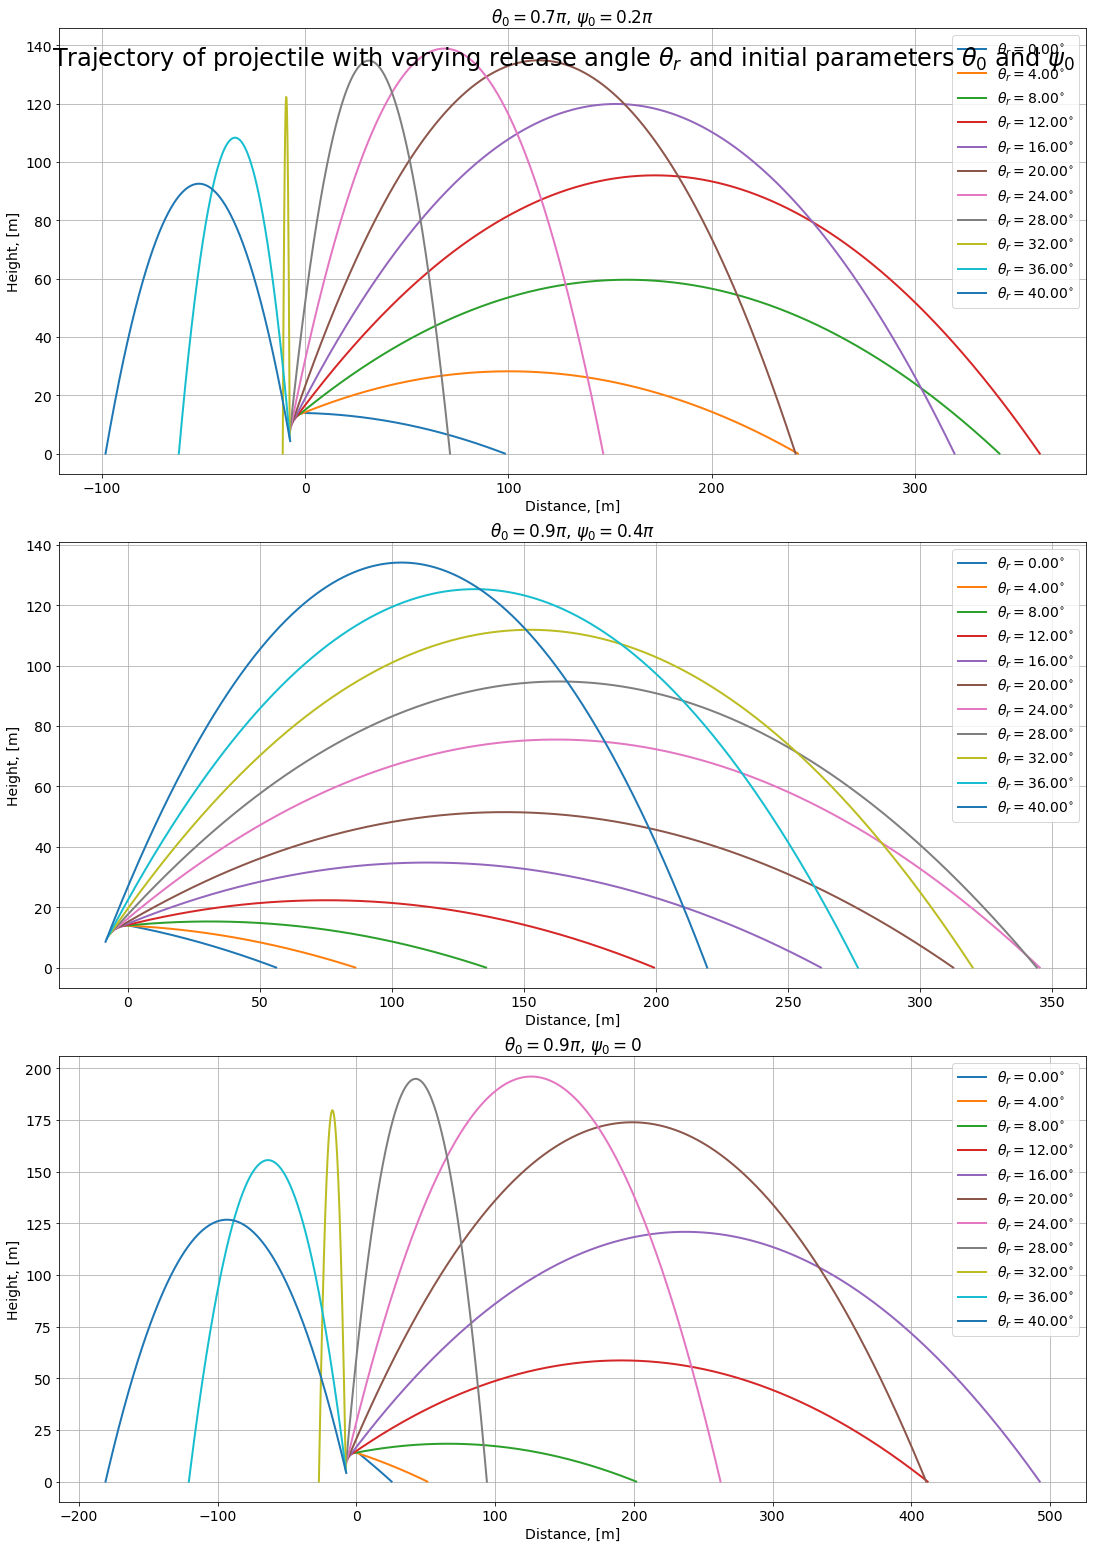

In [8]:
# Velocity of projectile in sling
def v_2b(w):
    return np.array([-l2*np.cos(w[0])*w[2] - l4*np.cos(w[1] - w[0])*(w[3] - w[2]),
                    -l2*np.sin(w[0])*w[2] + l4*np.sin(w[1] - w[0])*(w[3] - w[2])])

# Position of projectile in swing
def r_2b(w):
    return np.array([-l2*np.sin(w[0]) - l4*np.sin(w[1] - w[0]),
                    l2*np.cos(w[0]) + l3 - l4*np.cos(w[1] - w[0])])

init_params()

T_3 = 10
w0_3 = omega_trebuchet(theta0, psi0, dtheta0, dpsi0)
theta_r = np.linspace(0, 40*np.pi/180, 41) # Array with increasing release angles

# Plotting throws for three different combinations of initial angles
fig, axs = plt.subplots(3, figsize=(16, 22))
fig.suptitle(r"Trajectory of projectile with varying release angle $\theta_r$ and initial parameters $\theta_0$ and $\psi_0$", fontsize=24, y=0.96)
fig.tight_layout(pad=3)

x = np.zeros(len(theta_r))

for i, release_angle in enumerate(theta_r):

    t3, w3 = trebuchet(EOM_trebuchet, omega_trebuchet, w0_3, release_angle, T_3, h=0.005)

    # Last position and velocity in swing becoms initials in the flying motion
    v_initial = v_2b(w3[-1])
    r_initial = r_2b(w3[-1])

    r3, v3, time3, rl3 = projectile(EOM_projectile, omega_projectile, r_initial, v_initial, method=RK4, h=0.005)
    x[i] = r3[-1, 0]
    
    if r3[-1, 0] == .0 or i%4 == 0:
        axs[0].plot(r3[:, 0], r3[:, 1], label = fr'$\theta_r = {"{:.2f}".format(release_angle*180/np.pi)}^{{\circ}}$')
        axs[0].set_xlabel("Distance, [m]")
        axs[0].set_ylabel("Height, [m]")
        axs[0].set_title(rf"$\theta_0 = 0.7\pi$, $\psi_0 = 0.2\pi$")
        axs[0].legend()

# Finding what angles result in launch in positive x-direction
j = np.where(x<=0)
xmin = np.amax(x[j])
k = np.where(x==xmin)

display(Markdown(rf"Projectile travels in a positive x-directions for release angles smaller than ${'{:.0f}'.format(np.degrees(theta_r[j][0]))}^{{\circ}}$; $\theta_0 = 0.7\pi$, $\psi_0 = 0.2\pi$"))

# Changing the combination of initial angles and doing the same calculations
init_params(theta=0.9*np.pi)
w0_3 = omega_trebuchet(theta0, psi0, dtheta0, dpsi0)

for i, release_angle in enumerate(theta_r):
    
    t3, w3 = trebuchet(EOM_trebuchet, omega_trebuchet, w0_3, release_angle, T_3, h=0.005)
    
    v_initial = v_2b(w3[-1])
    r_initial = r_2b(w3[-1])

    r3, v3, time3, rl3 = projectile(EOM_projectile, omega_projectile, r_initial, v_initial, h=0.005)
    x[i] = r3[-1, 0]
    
    if r3[-1, 0] == .0 or i%4 == 0:
        axs[1].plot(r3[:, 0], r3[:, 1], label = fr'$\theta_r = {"{:.2f}".format(release_angle*180/np.pi)}^{{\circ}}$')
        axs[1].set_xlabel("Distance, [m]")
        axs[1].set_ylabel("Height, [m]")
        axs[1].set_title(rf"$\theta_0 = 0.9\pi$, $\psi_0 = 0.4\pi$")
        axs[1].legend()
    
display(Markdown(rf"Projectile travels in a positive x-directions for all release angles $\theta_r\in[0^{{\circ}}, 40^{{\circ}}]$; $\theta_0 = 0.9\pi$, $\psi_0 = 0.4\pi$"))

# Changing the combination of initial angles again and doing the same calculations
init_params(theta=0.9*np.pi, psi=0.9*np.pi)
w0_3 = omega_trebuchet(theta0, psi0, dtheta0, dpsi0)

for i, release_angle in enumerate(theta_r):

    t3, w3 = trebuchet(EOM_trebuchet, omega_trebuchet, w0_3, release_angle, T_3, h=0.005)

    v_initial = v_2b(w3[-1])
    r_initial = r_2b(w3[-1])

    r3, v3, time3, rl3 = projectile(EOM_projectile, omega_projectile, r_initial, v_initial, h=0.005)
    x[i] = r3[-1, 0]
    
    if r3[-1, 0] == .0 or i%4 == 0:
        axs[2].plot(r3[:, 0], r3[:, 1], label = fr'$\theta_r = {"{:.2f}".format(release_angle*180/np.pi)}^{{\circ}}$')
        axs[2].set_xlabel("Distance, [m]")
        axs[2].set_ylabel("Height, [m]")
        axs[2].set_title(rf"$\theta_0 = 0.9\pi$, $\psi_0 = 0$")
        axs[2].legend()

# Finding what angles result in launch in positive x-direction
j = np.where(x<=0)
xmin = np.amax(x[j])
k = np.where(x==xmin)

display(Markdown(rf"Projectile travels in a positive x-directions for release angles smaller than ${'{:.0f}'.format(np.degrees(theta_r[k][0]))}^{{\circ}}$; $\theta_0 = 0.9\pi$, $\psi_0 = 0.0\pi$"))

init_params()

The plots above shows a number of throws, for three different combinations of initial angles. For each throw, the trebuchet holds on to the projectile just a little bit longer, to see exactly for what angle the projectile travel farthest. With the first testing, meaning the first plot, some of the projectiles happen to land behind the initial position. Such a throw behind friendly lines during a war would be nothing short of a deadly embarrassment to the army. Even so, holding on to the projectile for too long also yield undesirable results since the stone is thrown almost straight into the ground. However, by releasing the projectile at the just the right moment, we can make it fly as long as $300$ meter forward.

And by increasing both the initial angles, we can see that the issue of throwing backwards is avoided. The longest distance obtain is about the same as before, but this time all the tosses are forward - towards the enemy. However, by setting the sling angle to zero, the last plot, we have returned to the backwards toss again. Yet, this combination of initial parameters, in addition to a perfect release angle, gives distances up to $500$ meters! The peak of the highest throw has also increased to almost $200$ meters in the air, although this stone does not travel as far. In the eyes of a soldier during the middle ages, a rock the size of a pumpkin can come soaring through the sky from half a kilometer away - and there is nothing to be done about it. 

What causes these different type of tosses is the compliance between the initial angles of the swing and beam. In addition, the release angle also plays a part, but we can see that even with the perfect release, the distance can increase with almost $200$ meters with the optimal starting angles. In the last case, where the sling angle equals zero, the motion of the sling will work in line with the motion of the beam. And as the beam starts swinging, the sling follows the same pattern and is dragged along to create the optimal velocity for the projectile. With just the right union of these two, the beam will "help" the sling with its motion. The opposite would be when the beam and sling are out of synchronization, and the result is a toss without the desired power.

## Task 4

Lastly, we will do our medieval army the favor of analyzing how the release angle $\theta_r$ affects two important parameters; slinging distance and impact energy. How should our soldiers calibrate the trebuchet if their feet are sore and want to maximize the distance of the projectile they are hurling, and in contrast how should they calibrate it to be fit for maximum destruction? To test this, we will simulate a handful of slings with same initial parameters but varying release angles. Then we will store the final position and velocity of each simulation, calculate kinetic energy and plot our results as functions of release angles. From this data we can find the optimal release angle for the desired purpose.


Maximum impact energy: $E = 30934.16 \text{ J}, \theta_r = 0^\circ$

Maximum range: $x = 363.99 \text{ m}, \theta_r = 11^\circ$

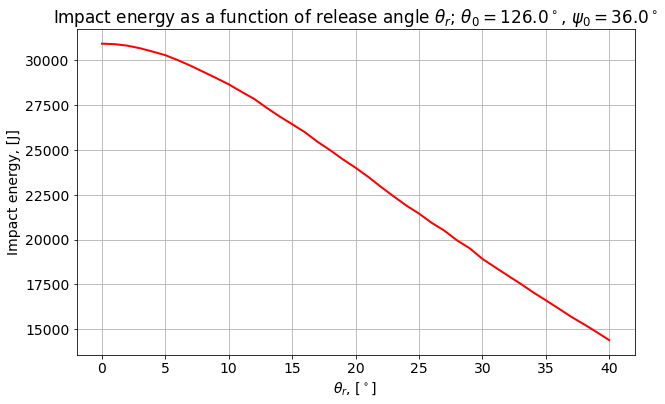

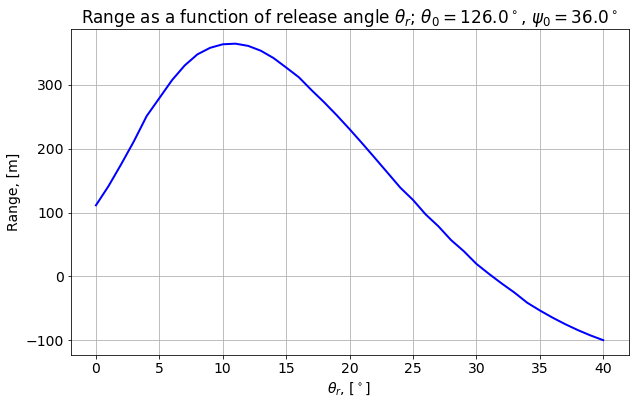

In [9]:
# Calculating kinetic energy
def KE(v):
    return 1/2*m2*norm(v)**2

init_params()

T_4 = 10
w0_4 = omega_trebuchet(theta0, psi0, dtheta0, dpsi0)
KE_impact = np.zeros(len(theta_r))
distance = np.zeros(len(theta_r))

for i, release_angle in enumerate(theta_r):

    t4, w4 = trebuchet(EOM_trebuchet, omega_trebuchet, w0_4, release_angle, T_4, h=0.001)

    v_initial4 = v_2b(w4[-1])
    r_initial4 = r_2b(w4[-1])
    
    r4, v4, time4, rl4 = projectile(EOM_projectile, omega_projectile, r_initial4, v_initial4)
    
    KE_impact[i] = KE(v4[-1])    # Array with impact energies for each angle
    distance[i] = rl4[0]         # Array with distances for each angle


# Plotting impact energy
plt.figure()
plt.plot(theta_r*(180/np.pi), KE_impact, 'r')
plt.title(fr"Impact energy as a function of release angle $\theta_r$; $\theta_0 = {theta0*(180/np.pi)}^\circ$, $\psi_0 = {psi0*(180/np.pi)}^\circ$")
plt.xlabel(fr"$\theta_r$, [$^\circ$]")
plt.ylabel(fr"Impact energy, [J]")

# Plotting distance
plt.figure()
plt.plot(theta_r*(180/np.pi), distance, 'b')
plt.title(fr"Range as a function of release angle $\theta_r$; $\theta_0 = {theta0*(180/np.pi)}^\circ$, $\psi_0 = {psi0*(180/np.pi)}^\circ$")
plt.xlabel(fr"$\theta_r$, [$^\circ$]")
plt.ylabel(fr"Range, [m]");

# Finding maximun impact energy and for which angle
KE_impact_max = np.amax(KE_impact)
KE_ind = np.where(KE_impact == KE_impact_max)

# Finding maximun distance and for which angle
distance_max = np.amax(distance)
distance_ind = np.where(distance == distance_max)

display(Markdown(fr"Maximum impact energy: $E = {'{:.2f}'.format(KE_impact_max)} \text{{ J}}, \theta_r = {'{:.0f}'.format(theta_r[KE_ind][0])}^\circ$"))
display(Markdown(fr"Maximum range: $x = {'{:.2f}'.format(distance_max)} \text{{ m}}, \theta_r = {'{:.0f}'.format(theta_r[distance_ind][0]*(180/np.pi))}^\circ$"))

An important fact to notice in these plots is that the optimal release angle for impact energy and range differ. For maximal impact energy, $\theta_r=0^{\circ}$ is the optimal release angle, while for maximal range $\theta_r=11^{\circ}$ is optimal. The optimal angle for impact energy comes from the fact that for $\theta_r=0^{\circ}$ all of the potential energy of the counter weight $m_1$ is converted into kinetic energy. Even though $m_1$ has transferred some of its energy into potential energy for $m_2$ in this position, this is a tiny energy compared to the kinetic energy $m_1$ has gained and in turn transferred to $m_2$. Since we are considering a conservative system with no friction and air resistance, all kinetic energy of the projectile at the time of release will be conserved for when the projectile hits its target, assuming it hits around the same height as it is launched. As for the optimal angle for range, the angle between the velocity vector of the projectile and the $x$\-axis at launch will have a huge effect. This means that even though the speed of the projectile is greatest when the kinetic energy is maximal, the angle at which it is hurled might not be optimal. This angle is determined by both the arm angle and the sling angle, meaning that the optimal release angle will be at a point where the release speed and angle collectively produce the initial conditions optimal for a long range throw. In our case, this is not for the release angle associated with the most kinetic energy.

# Conclusion



Even with our simplified model of a trebuchet, calculations can be made to give a reasonable estimate for how such a machine would work. We have looked at the periodic but somewhat chaotic motion of the swing, as well as the effects of initial conditions, release angle, and how the release angle affects the range and impact energy of the projectile. The chaotic motion of the trebuchet comes from the fact that it is in essence a form of a double pendulum, which in its nature is chaotic. In our case, the arm swings in a harmonic manner because of the large mass of the counter weight, but it is somewhat affected by the sling's chaotic motion. Fortunately for the attacking army, the chaotic motion does not kick in for full instantly, meaning that the launch is predictable. The initial arm angle dictates the amount of energy the launch will have, since it is the defining parameter for the potential energy of $m_2$. The initial sling angle will also affect the launch by changing the direction of the velocity of the projectile at release. Lastly, the release angle will affect both the amount of kinetic energy in the launch and the angle of the projectile's velocity. This becomes apparent while investigating how impact energy and range varies with the release angle. From this data one can also say that there is no doubt that this mighty weapon can tear down even the thickest walls, and give its wielders the upper hand in a war.
